<a href="https://colab.research.google.com/github/lfernandof/lfp_signals_analysis/blob/main/consistency_check_LFP_analyses.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Imports and installs

In [1]:
# IMPORTS AND INSTALLS
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.io as sio
import os
import json
import scipy
import pickle
import seaborn as sns


# ACCESS TO DATA
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Convert data from .mat into .csv and .npy files

In [ ]:
#should run at 'all_channels' folder

def data_from_mat(rat_id,day_id):

    animal_label = f'rat{rat_id}_day{day_id}_LFP_all'
    data = sio.loadmat('./data/'+animal_label+'_regions.mat')

    lfp = data[animal_label]['data'][0][0].T #using the transpose so its shape is (num_channels,num_points)
    timestamps = data[animal_label]['timestamps'][0][0]
    regions_listing = data[animal_label]['regions'][0][0][0]

    regions = {}
    metadata = {}
    metadata['total_duration'] = data[animal_label]['duration'][0][0][0][0]
    metadata['interval'] = data[animal_label]['interval'][0][0][0]
    metadata['sampling_rate'] = data[animal_label]['samplingRate'][0][0][0][0]

    #create a folder to store the data
    os.chdir('./data/separated_channels')
    os.makedirs(animal_label)

    #go inside this folder
    os.chdir(animal_label)

    #loop through the dataset
    for i in range(np.shape(lfp)[0]):
        label = f'ch{i}_{regions_listing[i][0]}'  #chX_region, channel in [0,31]
        #and region being either "PFC" or "STR"

        regions[label.split('_')[0]] = label.split('_')[1]

        #save each channel's activity as a .npy file
        np.save(file=label,arr=lfp[i,:])

    #save the timestamps to a .npy file
    np.save(file='timestamps',arr=timestamps)

    #save the channel-region correspondence into a file
    import json
    with open("channel_region", "w") as regions_file:
        json.dump(obj=regions,fp=regions_file)

#    with open('channel_region.txt','w') as regions_file:
#        regions_file.write(str(regions))

    #save the metadata to a text file
    with open('metadata.json','w') as metadata_file:
        metadata_file.write(str(metadata))

    #return to the former directory
    os.chdir('../../..')
    #and confirm whether it really is where one started
    print(os.getcwd())

In [ ]:
######## USE THIS ONE

data_path = '/content/drive/MyDrive/backup-mac/ufabc/entire-backup/lfp/all_channels/'
os.chdir(data_path)

#load auxiliary session data (trial segmenting times for all animals)
session_data = pd.read_csv('./data/session_data-spikes.csv').copy()

data_from_mat(rat_id=6,day_id=2)

KeyboardInterrupt: 

# Utilitary functions

In [2]:
#this should be run in the 'separated_channels' folder
def load_lfp(rat_id,day_id,channel_id):
    #file_path = f'./rat{rat_id}_day{day_id}_LFP_all'
    import json
    with open("./channel_region", "r") as fp:
        regions_listing = json.load(fp) #load the JSON with channel-region pairings
    region = regions_listing[f'ch{channel_id}'] #from it fetch the region for the current channel

    timestamps_data = np.squeeze(np.load('./timestamps.npy'))
    lfp_data = np.squeeze(np.load(f'./ch{channel_id}_'+region+'.npy'))

    df = pd.DataFrame.from_dict({'timestamps':timestamps_data,'lfp':lfp_data})
    return df,channel_id,region

#this should be run inside all_channels/data/separated_channels/______ (session)
def comodulogram_gif(trials_dict,ind_band=[1,20],dep_band=[30,200],ind_step=0.25,dep_step=2,ind_bandwidth=0.25,dep_bandwidth=2,
                     nbins=50,sampling_rate=1250):
#  lfp,ind_band=[1,20],dep_band=[20,200],ind_step=0.25,dep_step=2,
#                  ind_bandwidth=0.25,dep_bandwidth=2,num_bins=50,sampling_rate=1250
    os.mkdir('./comodulogram_gif')
    #generate each trial's comodulogram and save it to a .png file
    for trial_index in trials_dict.keys():
        current_lfp = trials_dict[trial_index].lfp.values
        comod, ind_freqs, dep_freqs = comodulogram2(current_lfp,ind_band=[1,20],dep_band=[25,200],ind_step=2,
                                                dep_step=5,ind_bandwidth=5,dep_bandwidth=10,
                                                num_bins=18,sampling_rate=1250)
        plot_comodulogram(comod,ind_freqs,dep_freqs,trial_index) #WRITE THIS FUNCTION HERE
        plt.savefig('./comodulogram_gif/'+trial_index+'.png',format='png')
        plt.close()

    #make a gif out of these images
    filenames = ['./comodulogram_gif/'+trial_index+'.png' for trial_index in trials_dict.keys()]
    import imageio as iio
    images = list()

    for file in filenames:
        images.append(iio.imread(file))

    iio.mimsave('./session_cfc.gif',images,format='GIF',duration=0.4)

##################################################################################

def compute_erp(trials_dict,norm_by_mean = True):
    #I should use the number of points in the shortest trial in the dictionary
    #for now, I will choose a random trial from the dictionary because all should have the same length
    from numpy import random
    series_length = len(trials_dict[random.choice(list(trials_dict.keys()))])

    num_trials = len(trials_dict)
    recipient = np.ndarray([num_trials,series_length])
    counter = 0
    for trial in trials_dict.keys():
        buffer_lfp = trials_dict[trial]['lfp']
        if norm_by_mean:
            buffer_lfp = buffer_lfp - np.mean(buffer_lfp)
        recipient[counter,:] = buffer_lfp
        counter+=1

    #the "ERP" is the mean along all trials
    erp = np.mean(recipient,axis=0)
    return erp,recipient

def erp_comodulogram(erp_signal,erp_label):
    comod,ind_freqs,dep_freqs = comodulogram2(erp_signal,ind_band=[1,20],dep_band=[20,200],ind_step=2,dep_step=5,
                                ind_bandwidth=4,dep_bandwidth=10,num_bins=18,sampling_rate=1250)
    plot_comodulogram(comod,ind_freqs,dep_freqs,trial_index='')
    plt.savefig('./erp_comodulogram/'+erp_label+'.png',format='png')

    plt.close()

In [3]:
# This should be run inside all_channels/data/separated_channels/______ (session)
def comodulogram_per_trial(trials_dict,ind_band=[1,20],dep_band=[20,200],ind_step=0.25,dep_step=2,
                  ind_bandwidth=0.25,dep_bandwidth=2,num_bins=50,sampling_rate=1250):
    '''
    Estimate the comodulogram using data from each trial. Save the plots separately indicating which trial it belongs to and the comodulograms themselves in a dictionary.
    '''

    os.mkdir('./individual_trial_comodulograms')

    comodulograms_dict = {}

    # Generate each trial's comodulogram and save it to a .png file
    for trial_index in trials_dict.keys():
        print(trial_index)
        current_lfp = trials_dict[trial_index].lfp.values
        comod, ind_freqs, dep_freqs = comodulogram2(current_lfp,ind_band,dep_band,ind_step,
                                                dep_step,ind_bandwidth,dep_bandwidth,
                                                num_bins,sampling_rate)

        #plot_comodulogram(comod,ind_freqs,dep_freqs,trial_index) #WRITE THIS FUNCTION HERE
        #plt.savefig('./individual_trial_comodulograms/'+trial_index+'.png',format='png')
        #plt.close()

        # Save all comodulograms into a dictionary
        comodulograms_dict[trial_index] = comod

    # Also save the independent and dependent frequencies for later use (e.g. plotting one of them again)
    comodulograms_dict['ind_freqs'] = ind_freqs
    comodulograms_dict['dep_freqs'] = dep_freqs

    with open('./individual_trial_comodulograms/comodulograms_dict.pkl', 'wb') as f:
      pickle.dump(comodulograms_dict, f)

def compute_erp(trials_dict,norm_by_mean = True):
    #I should use the number of points in the shortest trial in the dictionary
    #for now, I will choose a random trial from the dictionary because all should have the same length
    from numpy import random
    series_length = len(trials_dict[random.choice(list(trials_dict.keys()))])

    num_trials = len(trials_dict)
    recipient = np.ndarray([num_trials,series_length])
    counter = 0
    for trial in trials_dict.keys():
        buffer_lfp = trials_dict[trial]['lfp']
        if norm_by_mean:
            buffer_lfp = buffer_lfp - np.mean(buffer_lfp)
        recipient[counter,:] = buffer_lfp
        counter+=1

    #the "ERP" is the mean along all trials
    erp = np.mean(recipient,axis=0)
    return erp,recipient

def erp_comodulogram(erp_signal,erp_label):
    comod,ind_freqs,dep_freqs = comodulogram2(erp_signal,ind_band=[1,20],dep_band=[20,200],ind_step=2,dep_step=5,
                                ind_bandwidth=4,dep_bandwidth=10,num_bins=18,sampling_rate=1250)
    plot_comodulogram(comod,ind_freqs,dep_freqs,trial_index='')
    plt.savefig('./erp_comodulogram/'+erp_label+'.png',format='png')

    plt.close()

In [4]:
def split_lfp_trials(session_df,lfp_df,rat_id,day_id,region_id,min_duration=0.8,sampling_rate=1250,
                      slicing='first',peri_trial_inclusion = 0,per_slice=1500):
    elegible_trials = session_df.query(f"rat == {rat_id} & day == {day_id} &\
    region == '{region_id}' & duration >= {min_duration}")
    elegible_trials = elegible_trials.sort_values('trial').copy()

    #separate the lfp df into a dictionary of trials, whose keys are trial identifiers and
    #values are dfs corresponding to excerpts of the whole lfp signal that fall between
    #each trials' time boundaries [trial begin, trial end]

    trials_dict = {}
    for trial in elegible_trials.trial.unique():
        '''upon profiling this function to probe its performance I have concluded it is very slow
        the pieces of code that were taking too long were these queries below, so I'll comment them out and implement another querying method (expression matching on Series.values)
        nonetheless, I will leave them for the sake of comprehension of what is going on in the following expression, which yields the same but in a fraction of the elapsed time
        '''

        #select the current trial in the behavioral/spikes dataframe
        #current_trial = elegible_trials.query(f"trial == {int(trial)}")
        current_trial = elegible_trials[elegible_trials.trial.values == int(trial)]

        #extract the timestamps for the beginning and end of trial using the 1st
        #spike (begin) and total duration (end)
        begin = current_trial.iloc[0].timestamp - current_trial.iloc[0].time
        end = begin + current_trial.iloc[0].duration

        #fetch the lfp data within these two timepoints and add to the dict as our trial
        #current_lfp = lfp_df.query(f"timestamps >= {begin-peri_trial_inclusion} & timestamps <= {end}")
        current_lfp = lfp_df[(lfp_df.timestamps.values >= (begin-peri_trial_inclusion)) & (lfp_df.timestamps.values <= end)]

        if slicing == 'first':
                trials_dict[f'trial_{int(trial)}'] = current_lfp.head(per_slice)
        elif slicing == 'last':
            trials_dict[f'trial_{int(trial)}'] = current_lfp.tail(per_slice)
        elif slicing == 'none':
            trials_dict[f'trial_{int(trial)}'] = current_lfp
    print('done parsing the LFP into trials')

    return trials_dict

#new version: soon i'll simply delete the other implementation of these two above

def comodulogram2(lfp,ind_band=[1,20],dep_band=[20,200],ind_step=0.25,dep_step=2,
                  ind_bandwidth=0.25,dep_bandwidth=2,num_bins=50,sampling_rate=1250,verbosity=False):
  '''
  estimate the modulation index for pairs of frequencies {modulating,modulated}, each spanning a range of values
  '''

  freqs_for_amps = np.arange(dep_band[0],dep_band[1]+dep_step,dep_step)
  freqs_for_phases = np.arange(ind_band[0],ind_band[1]+ind_step,ind_step)

  filtered_phases = np.empty([len(freqs_for_phases) - 1,len(lfp)])

  from scipy.signal import hilbert

  for phase_index,phase in enumerate(freqs_for_phases[0:-1]):
    filtered_phases[phase_index,:] = np.angle(hilbert(band_extraction(lfp,cutoff_low=freqs_for_phases[phase_index],cutoff_high=freqs_for_phases[phase_index+1],
                                              sampling_rate=sampling_rate)))

  comod = np.zeros([len(freqs_for_amps) - 1, len(freqs_for_phases)])

  phasebins = np.linspace(-np.pi,np.pi,num_bins+1)
  phasecenters = phasebins[0:-1] + (phasebins[1] - phasebins[0])

  #iterate over signals filtered at higher frequencies (each band for which we extract the amplitude envelope)
  for amp_index,current_amp in enumerate(freqs_for_amps[:-1]):
    if verbosity:
      print(f'Progress: [{amp_index+1}/{len(freqs_for_amps)-1}]')

    amp_envelope = abs(hilbert(band_extraction(lfp,cutoff_low=freqs_for_amps[amp_index],cutoff_high=freqs_for_amps[amp_index+1],
                                                      sampling_rate=sampling_rate)))

    '''
    to exploit the storage vs. processing conundrum, I have already filtered the signal in each low-frequency band of interest
    and put each band's signal in a vector (filtered_phases, 76 bands in total).
    once again I have opted for such an approach and below I create a vector called bins_freq,
    that will store each frequency bin's (from [-pi,pi]) mean amplitude in a single modulated band (from which we extract the amplitude envelope)
    '''

    bins_freq = np.empty((num_bins,len(filtered_phases)))

    for phase_bin_id in range(len(phasebins)-1):
      #print(phase_bin_id)
      #print(phasebins[phase_bin_id],phasebins[phase_bin_id+1])

      for band_id,band_signal in enumerate(filtered_phases):
        phasepoints_in_frequency_bin = np.where((band_signal > phasebins[phase_bin_id]) & (band_signal < phasebins[phase_bin_id+1]))[0]
        mean_amplitude_in_frequency_bin = np.mean(amp_envelope[phasepoints_in_frequency_bin])
        #print(mean_amplitude_in_frequency_bin)
        bins_freq[phase_bin_id,band_id] = mean_amplitude_in_frequency_bin

      #print(f'estimated mean amplitude in bin {phase_bin_id} [{phasebins[phase_bin_id]} Hz, {phasebins[phase_bin_id+1]} Hz] in all modulating bands!')
      #print(sum(bins_freq[:,band_id]))
    if verbosity:
      print(f'finished all frequency bins for all modulating bands in this modulated band: [{freqs_for_amps[amp_index]} Hz,{freqs_for_amps[amp_index+1]} Hz]')
    #normalize over each phase bin, yielding what is dubbed p
    p = [bins_freq[:,band_id]/sum(bins_freq[:,band_id]) for band_id in range(len(filtered_phases))]

    #estimate MI
    from scipy.stats import entropy
    uniform_dist = np.ones(num_bins)/num_bins

    #iterating over all low-frequency filtered bands:
    for low_freq_band_index in range(np.shape(p)[0]):
      MI = entropy(p[low_freq_band_index],uniform_dist)/np.log(num_bins)
      comod[amp_index,low_freq_band_index] = MI

  return comod,freqs_for_phases,freqs_for_amps

def plot_comodulogram(comod,ind_freqs,dep_freqs,trial_index=''):
    #make a grid to accommodate the data
    x,y = np.meshgrid(ind_freqs,dep_freqs[:-1])

    plt.contourf(x, y, comod, 30, cmap=plt.cm.viridis)
    plt.title(f'Trial: {trial_index}')
    plt.xlabel('Independent \n frequency (Hz)',size=13)
    plt.ylabel('Dependent \n frequency (Hz)',size=13)
    plt.colorbar(label="Modulation Index (MI)")

def band_extraction(lfp_data,cutoff_low,cutoff_high,sampling_rate=1250,order=3):
    '''Filter the broadband LFP signal, allowing only frequencies between the limits [cutoff_low,cutoff_high]
    using a FIR bandpass filter with a Hamming window whose length.

    INPUT:
        - lfp_data: a pandas Series object containing the signal to be filtered (i.e. the LFP);
        - cutoff_low: the lowest frequency allowed;
        - cutoff_high: the highest frequency allowed;
        - sampling_rate: in Hz [default: 1250];
        - order: the order of the Butter filter employed [default: 3]

    OUTPUT:
        - the filtered signal as a 1D numpy array;
    '''

    from scipy.signal import butter, firwin, lfilter, filtfilt

    #Design the filter
    nyquist_freq = 0.5*sampling_rate
    inf_threshold = cutoff_low/nyquist_freq
    sup_threshold = cutoff_high/nyquist_freq

    #order is given in cycles; transform it into samples by multiplying by the sampling rate frequency
    filter_length = round(order*(2*nyquist_freq)/cutoff_high)

    #b,a = butter(order,[inf_threshold,sup_threshold],btype='bandpass')
    #a = scipy.signal.firwin(n, cutoff = [0.016, 0.02], window = 'hamming', pass_zero = False)
    h = firwin(filter_length,cutoff = [inf_threshold,sup_threshold],window='hamming',pass_zero=False)

    #Return the filter applied to the signal
    #return filtfilt(h,1,lfp_data) #TEMPORARY ADJUSTMENT, JUST TO TEST (26/09/23)
    return filtfilt(h,1,lfp_data,padtype=None)

#Calculate 20*log10(x) without printing an error when x=0
def dB20(array):
    with np.errstate(divide='ignore'):
        return 20 * np.log10(array)

def filter_response_plot(b,a,cutoffs):
  w, h = scipy.signal.freqz(b,a)
  h = abs(h) #the frequency-response h is given as a complex number, but the amplitude at each frequency is its absolute value
  #w,dB20(h): #y in decibels, log in the frequency plane x
  plt.plot(w,dB20(h))
  plt.title('Filter frequency response')
  plt.ylabel('Amplitude [dB]')
  plt.xlabel('Frequency (rad/sampling rate)')

  plt.grid(which='both', axis = 'both')
  for cutoff_freq in cutoffs:
    plt.axvline(cutoff_freq,color='green')
  plt.show()

# Constants and data sets

In [5]:
# Best channel for each session (animal, day)
session_preferred_channels = {'rat3_day1': 11,
                              'rat3_day2': 11,
                              'rat4_day1': 18,
                              'rat4_day2': 18,
                              'rat5_day1': 9,
                              'rat5_day2': 9,
                              'rat6_day1': 10,
                              'rat6_day2': 10}

# Cross-frequency coupling during the trials

Estimated from one channel per rat on all its trials with at least 800 ms.

### Figures to generate:
Panel 1:
- Average comodulogram on early vs. late trials

Panel 2:
- Panel with many comodulograms from non-consecutive trials (5 panels per row, one row per animal)

Panel 3:
- MI Curve (as in Tort et al., 2008)

In [ ]:
#this should run at the "lfp/all_channels" folder

data_path = '/content/drive/MyDrive/backup-mac/ufabc/entire-backup/lfp/all_channels/'
os.chdir(data_path)
print(os.getcwd())
session_data = pd.read_csv('./data/session_data-spikes.csv').copy()

import itertools

criterion_duration = 1.5 # Segments of at least 1500 ms (i.e. rewarded trials) are included

#iterate over all sessions: rats {3,4,5,6} with recordings in days {1,2} each
for rat_day_pair in itertools.product(list(range(3,7)),list(range(1,3))):
    rat = rat_day_pair[0]
    day = rat_day_pair[1]
    print('rat: ',rat,'day: ',day)

    animal_label = f'rat{rat}_day{day}'

    os.chdir(f'./data/separated_channels/{animal_label}_LFP_all')
    print('current session: ',os.getcwd())

    if not os.path.isdir('./results'):
      print('Results folder created.')
      os.mkdir('./results')
    else:
      print('Results folder already existent.')


    print('Beginning the in-trial CFC analysis.')

    '''THIS HERE HAS BEEN BUGGING FOR NO APPARENT REASON IN THE LAST SESSION. THE FILE EXISTS AND CAN BE LISTED WITH OS.LISTDIR() BUT IT SAYS "FILE NOT FOUND".
     MY SOLUTION IS SIMPLY TO INPUT THE SAMPLING RATE BY HAND, WHICH IS EASY BECAUSE IT IS THE SAME IN ALL SESSIONS AND IS A SOLE INTEGER NUMBER'''
    #with open("./metadata.json", "r") as fp:
    #    meta_data = json.load(fp) #load the JSON with metadata
    #data_sampling_rate = meta_data['sampling_rate'] #from it fetch the sampling rate of the loaded data
    data_sampling_rate = 1250

    channel = session_preferred_channels[animal_label]
    print('Session: ',animal_label,'\nChannel: ',channel)


    # Load the LFP for that channel
    lfp,_,region = load_lfp(rat_id = rat,day_id = day,channel_id = channel)

    # Convert the inclusion criterion for duration from seconds into a number of points via the sampling rate
    points_per_trial = int(criterion_duration*data_sampling_rate)

    # Separate the continuous LFP signal into the segments corresponding to each trial
    current_trials_dict = split_lfp_trials(session_df = session_data,lfp_df = lfp,rat_id = rat,day_id = day,region_id = region,
                                              min_duration= criterion_duration,sampling_rate= data_sampling_rate,
                                                slicing= 'first',peri_trial_inclusion=0,per_slice = points_per_trial)

    print(len(current_trials_dict))
    # Go to the folder where results will be stored
    os.chdir('./results')

    # Compute the comodulograms for each trial
    comodulogram_per_trial(current_trials_dict)

    print(f'done with channel {channel} from session {animal_label}')

    # Clear variables
    del lfp, channel, region, points_per_trial,current_trials_dict

    os.chdir('../../../..') # Go back into 'data/separated_channels'
print('all done!')

/content/drive/MyDrive/backup-mac/ufabc/entire-backup/lfp/all_channels
rat:  6 day:  2
current session:  /content/drive/MyDrive/backup-mac/ufabc/entire-backup/lfp/all_channels/data/separated_channels/rat6_day2_LFP_all
Results folder created.
Beginning the in-trial CFC analysis.
Session:  rat6_day2 
Channel:  10
done parsing the LFP into trials
380
trial_3
trial_9
trial_10
trial_12
trial_16
trial_18
trial_20
trial_21
trial_23
trial_32
trial_34
trial_37
trial_38
trial_39
trial_44
trial_45
trial_48
trial_49
trial_50
trial_52
trial_57
trial_58
trial_63
trial_65
trial_66
trial_67
trial_68
trial_72
trial_81
trial_84
trial_89
trial_91
trial_111
trial_113
trial_122
trial_123
trial_126
trial_127
trial_134
trial_137
trial_141
trial_145
trial_149
trial_151
trial_153
trial_154
trial_155
trial_161
trial_162
trial_164
trial_167
trial_168
trial_171
trial_172
trial_173
trial_179
trial_181
trial_182
trial_183
trial_187
trial_188
trial_190
trial_192
trial_193
trial_194
trial_195
trial_198
trial_199
tria

/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


trial_404
trial_405
trial_406
trial_407
trial_408
trial_409
trial_414
trial_417
trial_419
trial_421
trial_422
trial_425
trial_426
trial_427
trial_428
trial_429
trial_430
trial_431
trial_432
trial_433
trial_434
trial_435
trial_436
trial_437
trial_438
trial_440
trial_441
trial_442
trial_444
trial_445
trial_446
trial_448
trial_449
trial_452
trial_453
trial_456
trial_457
trial_459
trial_460
trial_461
trial_462
trial_463
trial_464
trial_467
trial_468
trial_469
trial_470
trial_474
trial_475
trial_476
trial_477
trial_481
trial_482
trial_485
trial_488
trial_491
trial_492
trial_493
trial_495
trial_496
trial_498
trial_499
trial_500
trial_501
trial_502
trial_503
trial_504
trial_506
trial_507
trial_508
trial_509
trial_510
trial_511
trial_512
trial_513
trial_515
trial_516
trial_517
trial_518
trial_521
trial_522
trial_523
trial_524
trial_525
trial_527
trial_528
trial_529
trial_530
trial_531
trial_532
trial_533
trial_534
trial_535
trial_536
trial_537
trial_538
trial_539
trial_540
trial_541
trial_543


In [ ]:
os.chdir('/content/drive/MyDrive/backup-mac/ufabc/entire-backup/lfp/all_channels/data/separated_channels/rat6_day2_LFP_all/results/individual_trial_comodulograms')

with open('comodulograms_dict.pkl', 'rb') as f:
    loaded_dict = pickle.load(f)

In [ ]:
loaded_dict.keys()

dict_keys(['trial_3', 'trial_9', 'trial_10', 'trial_12', 'trial_16', 'trial_18', 'trial_20', 'trial_21', 'trial_23', 'trial_32', 'trial_34', 'trial_37', 'trial_38', 'trial_39', 'trial_44', 'trial_45', 'trial_48', 'trial_49', 'trial_50', 'trial_52', 'trial_57', 'trial_58', 'trial_63', 'trial_65', 'trial_66', 'trial_67', 'trial_68', 'trial_72', 'trial_81', 'trial_84', 'trial_89', 'trial_91', 'trial_111', 'trial_113', 'trial_122', 'trial_123', 'trial_126', 'trial_127', 'trial_134', 'trial_137', 'trial_141', 'trial_145', 'trial_149', 'trial_151', 'trial_153', 'trial_154', 'trial_155', 'trial_161', 'trial_162', 'trial_164', 'trial_167', 'trial_168', 'trial_171', 'trial_172', 'trial_173', 'trial_179', 'trial_181', 'trial_182', 'trial_183', 'trial_187', 'trial_188', 'trial_190', 'trial_192', 'trial_193', 'trial_194', 'trial_195', 'trial_198', 'trial_199', 'trial_207', 'trial_209', 'trial_213', 'trial_214', 'trial_215', 'trial_220', 'trial_226', 'trial_228', 'trial_229', 'trial_230', 'trial_23

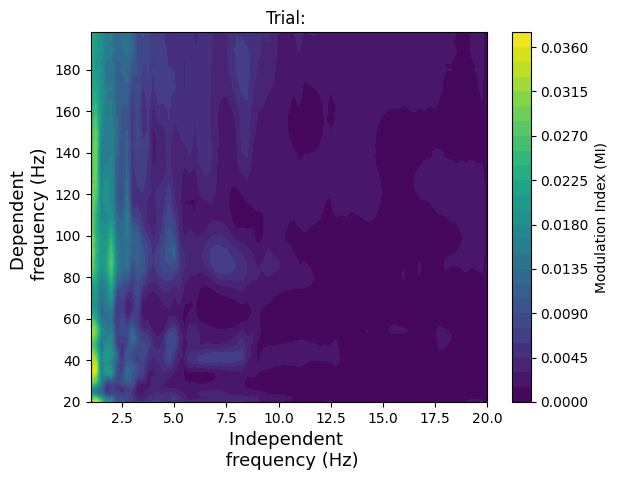

In [ ]:
plot_comodulogram(loaded_dict['trial_694'],loaded_dict['ind_freqs'],loaded_dict['dep_freqs'])

In [ ]:
def max_comod_values_df(trialed_comodulograms_dict,rat_id,day_id):
  #keys are strings like "trial_$"; keeping only the integer identifier allows for arithmetic operations on the trial column of the resulting dataframe
  return pd.DataFrame.from_dict({'trial':[[int(key[6:])]],'max_comod_value':[max(np.flatten(value))] for key,value in loaded_dict.items(),'rewarded':True,'rat':rat_id,'day':day_id})

#fazer um negocio pra inserir as trials sem recompensa com valor maximo NaN ou sei la.. algo que nao afete a media movel?

# testing the MI/comodulogram estimation algorithm

### Sleep data

In [33]:
data_path = '/content/drive/MyDrive/backup-mac/ufabc/entire-backup/lfp/all_channels/'
os.chdir(data_path)

data_states = sio.loadmat('./data/state_scoring/rat4_day2/2017-05-07_13-57-27.SleepState.states.mat')

data_episodes = sio.loadmat('./data/state_scoring/rat4_day2/2017-05-07_13-57-27.SleepStateEpisodes.states.mat')

data_scores = sio.loadmat('./data/state_scoring/rat4_day2/2017-05-07_13-57-27.SleepScoreLFP.LFP.mat')

In [34]:
#load data from rat 4, day 2:
data_path = '/content/drive/MyDrive/backup-mac/ufabc/entire-backup/lfp/all_channels/'
os.chdir(data_path)

rat = 4
day = 2

animal_label = f'rat{rat}_day{day}'

os.chdir(f'./data/separated_channels/{animal_label}_LFP_all')
print('current session: ',os.getcwd())

#with open("./metadata.json", "r") as fp:
#    meta_data = json.load(fp) #load the JSON with metadata
#data_sampling_rate = meta_data['sampling_rate'] #from it fetch the sampling rate of the loaded data
#data_sampling_rate = 1250

lfp,channel,region = load_lfp(rat_id = rat,day_id = day,channel_id = 18)

current session:  /content/drive/MyDrive/backup-mac/ufabc/entire-backup/lfp/all_channels/data/separated_channels/rat4_day2_LFP_all


In [35]:
#This encodes the timestamps [begin, end] for each event of a given state
#data_states['SleepState'][0][0][0][0]

#Timestamps for awake states
awake_timestamps = data_states['SleepState'][0][0][0][0][0][0]

#Timestamps for pathological states
pathological_timestamps = data_states['SleepState'][0][0][0][0][0][1]

#Timestamps for NREM states
nrem_timestamps = data_states['SleepState'][0][0][0][0][0][2]

#Timestamps for REM states
rem_timestamps = data_states['SleepState'][0][0][0][0][0][3]

#'''caution: I have figured which timestamps belong to which state due to the dtypes assigned at the level of "data_states['SleepState'][0][0][0][0]", but it might be a mistake of mine

In [72]:
freqs_for_amps = np.arange(30,202,2)
freqs_for_phases = np.arange(1,20.25,.25)

print(len(freqs_for_phases),len(freqs_for_amps))

77 86


In [37]:
first_asleep_state = lfp.query(f'timestamps > {nrem_timestamps[0][0]} and timestamps <= {nrem_timestamps[0][1]}')
first_awake_state = lfp.query(f'timestamps > {awake_timestamps[0][0]} and timestamps <= {awake_timestamps[0][1]}')
first_pathological_state = lfp.query(f'timestamps > {pathological_timestamps[0][0]} and timestamps <= {pathological_timestamps[0][1]}')

2632 3010
7280 8335


Text(0, 0.5, 'LFP')

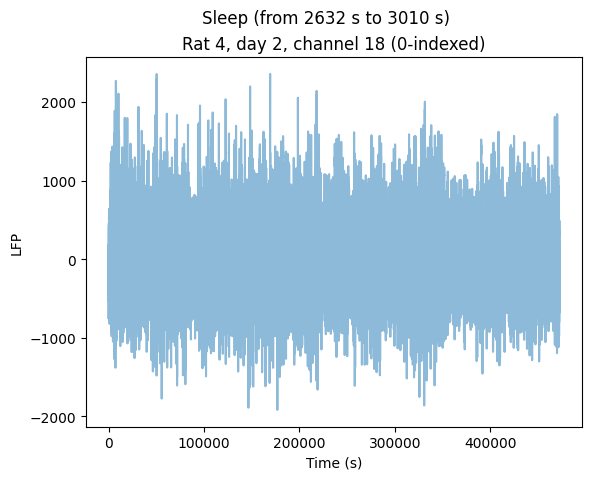

In [38]:
print(nrem_timestamps[0][0],nrem_timestamps[0][1])
print(nrem_timestamps[1][0],nrem_timestamps[1][1])

#vamos escolher o primeiro período de sono:
[nrem_timestamps[i][1] - nrem_timestamps[i][0] for i in range(len(nrem_timestamps))]

signal = lfp.query(f'timestamps > {nrem_timestamps[0][0]} and timestamps <= {nrem_timestamps[0][1]}').lfp.values
plt.suptitle(f'Sleep (from {nrem_timestamps[0][0]} s to {nrem_timestamps[0][1]} s)')
plt.title('Rat 4, day 2, channel 18 (0-indexed)')
plt.plot(signal,alpha=0.5)
plt.xlabel('Time (s)')
plt.ylabel('LFP')
#plt.xticks(plt.xticks()[0],labels = [int(tick)/1250 + nrem_timestamps[0][0] for tick in plt.xticks()[0]])
#plt.xlim(left=-5000,right=480000.0)

In [43]:
comod, ind_freqs, dep_freqs = comodulogram2(signal)

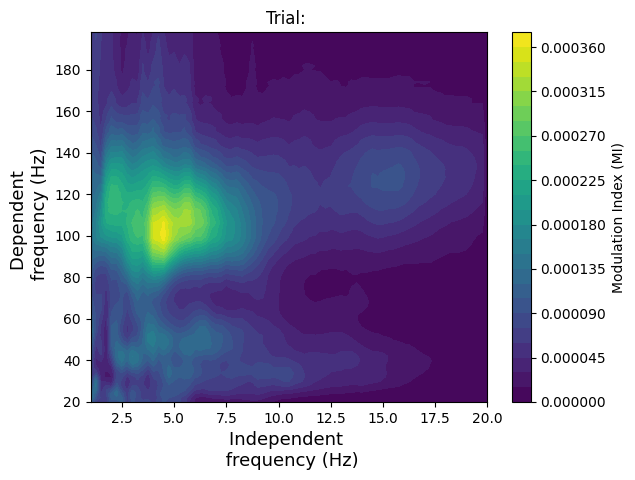

In [44]:
plot_comodulogram(comod,ind_freqs,dep_freqs)

(90, 77) (77,) (90,)


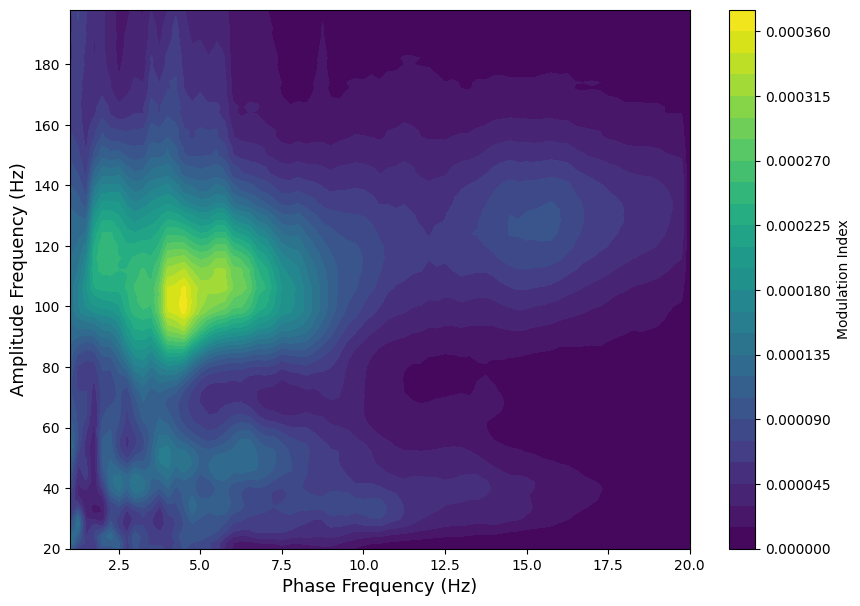

In [ ]:
#dimensions
print(np.shape(comod),np.shape(ind_freqs),np.shape(dep_freqs[0:-1]))

#contour plot
plt.figure(figsize=(10,7))
plt.contourf(ind_freqs,dep_freqs[0:-1],comod,30)
plt.xlabel('Phase Frequency (Hz)',size=13)
plt.ylabel('Amplitude Frequency (Hz)',size=13)
plt.colorbar(label="Modulation Index");

# Cross-frequency coupling during NREM sleep

Estimated from one channel per rat on all its asleep periods

### Figures to generate:
Panel 1:
- Average comodulogram before training vs. after training

Panel 2:
- Point plot comparing MI values before/after training (as in Eliezyer's dissertation, fig. 3.2.3.g-h)

In [32]:
def separate_intervals(state_timestamps,session_data,rat_id,day_id):
  '''
  Separate the intervals of a given state (REM sleep, nREM sleep, awake or micro-seizure) as happening either before or after training
  discarding whichever interval happens within the training session

  Parameters
  ----------
  state_timestamps: iterable
          The LFP signal whose bands will be probed for coupling
  session_data: pandas DataFrame
          A DataFrame containing all information regarding the sessions, including the beginning/end timestamps of each one
  rat_id: int
          The chosen animal
  day_id: int
          The day in which the session happened

  Returns
  ----------
  state_ocurrences_before_training,state_ocurrences_after_training: list
          Selection of states that happen respectively before/after training

  '''


  state_ocurrences_before_training = []
  state_ocurrences_after_training = []

  #Query for the desired session and find the first and last timestamp, corresponding to the beginning and end of the training protocol during this session
  training_begin = session_data.query(f'rat == {rat_id} and day == {day_id}').timestamp.min()
  training_end = session_data.query(f'rat == {rat_id} and day == {day_id}').timestamp.max()
  #print(training_begin,training_end)

  for sleep_period_index,period_limits in enumerate(state_timestamps):
    if period_limits[0] < training_begin:
      state_ocurrences_before_training.append(state_timestamps[sleep_period_index])
    elif period_limits[0] > training_end:
      state_ocurrences_after_training.append(state_timestamps[sleep_period_index])
    else:
      pass

  return state_ocurrences_before_training,state_ocurrences_after_training

def split_lfp_states(lfp_df,timestamps_list):

    '''separate the lfp df into a dictionary of segments, whose keys are segment identifiers (index in the timestamps list) and
    values are dfs corresponding to excerpts of the whole lfp signal that fall between
    each state's time boundaries [state begin, state end]'''

    states_dict = {}
    for state_id,state_limiting_timestamps in enumerate(timestamps_list):
        '''upon profiling this function to probe its performance I have concluded it is very slow
        the pieces of code that were taking too long were these queries below, so I'll comment them out and implement another querying method (expression matching on Series.values)
        nonetheless, I will leave them for the sake of comprehension of what is going on in the following expression, which yields the same but in a fraction of the elapsed time
        '''

        #extract the timestamps for the beginning and end of trial using the 1st
        #spike (begin) and total duration (end)
        begin = state_limiting_timestamps[0]
        end = state_limiting_timestamps[1]

        #fetch the lfp data within these two timepoints and add to the dict as our state
        current_lfp = lfp_df[(lfp_df.timestamps.values >= (begin)) & (lfp_df.timestamps.values <= end)].lfp.values

        states_dict[state_id] = current_lfp
    print('done parsing the LFP into state intervals')

    return states_dict

def estimate_comodulogram(signal,modulating_freqs,modulated_freqs,num_bins=50,sampling_rate=1250):
  '''
  Estimate the Modulation Index (MI) for each pair of frequencies (one whose phase is modulating the amplitude of the other) among all specified
  and return the matrix with all the MIs (the comodulogram).

  Parameters
  ----------
  signal: (NumPy) array
          The LFP signal whose bands will be probed for coupling
  modulating_freqs: iterable
          The modulating frequencies (Hz) in crescent order (e.g. [1,1.25,1.5,...,20])
  modulated_freqs: iterable
          The modulated frequencies (Hz) in crescent order (e.g. [20,22,24,...,200])
  num_bins: int [default: 50]
          Number of bins in which to divide the phase of the modulating frequency (e.g. 360 deg/50 bins = 7.2 deg per bin)
  sampling_rate: float [default: 1250]
          The sampling rate of the original signal

  Returns
  ----------
  current_comod: (NumPy) array
          A 2D matrix comprised of the MI for each pair of frequencies in both the modulating and modulated ranges
  '''

  current_comod = np.zeros([len(modulated_freqs) - 1, len(modulating_freqs)])

  filtered_phases = np.empty([len(modulating_freqs) - 1,len(signal)])

  from scipy.signal import hilbert

  for phase_index,phase in enumerate(modulating_freqs[0:-1]):
    filtered_phases[phase_index,:] = np.angle(hilbert(band_extraction(signal,cutoff_low=modulating_freqs[phase_index],cutoff_high=modulating_freqs[phase_index+1],
                                              sampling_rate=sampling_rate)))

  phasebins = np.linspace(-np.pi,np.pi,num_bins+1)
  phasecenters = phasebins[0:-1] + (phasebins[1] - phasebins[0])


  #iterate over signals filtered at higher frequencies (each band for which we extract the amplitude envelope)
  for amp_index,current_amp in enumerate(modulated_freqs[:-1]):
    #print(f'new amp: [{amp_index}/{len(modulated_freqs)-1}]')
    amp_envelope = abs(hilbert(band_extraction(signal,cutoff_low=modulated_freqs[amp_index],cutoff_high=modulated_freqs[amp_index+1],
                                                    sampling_rate=sampling_rate)))

    '''
    to exploit the storage vs. processing conundrum, I have already filtered the signal in each low-frequency band of interest
    and put each band's signal in a vector (filtered_phases, 76 bands in total).
    once again I have opted for such an approach and below I create a vector called bins_freq,
    that will store each frequency bin's (from [-pi,pi]) mean amplitude in a single modulated band (from which we extract the amplitude envelope)
    '''

    bins_freq = np.empty((num_bins,len(filtered_phases)))

    for phase_bin_id in range(len(phasebins)-1):
      #print(phase_bin_id)
      #print(phasebins[phase_bin_id],phasebins[phase_bin_id+1])

      for band_id,band_signal in enumerate(filtered_phases):
        phasepoints_in_frequency_bin = np.where((band_signal > phasebins[phase_bin_id]) & (band_signal < phasebins[phase_bin_id+1]))[0]
        mean_amplitude_in_frequency_bin = np.mean(amp_envelope[phasepoints_in_frequency_bin])
        #print(mean_amplitude_in_frequency_bin)
        bins_freq[phase_bin_id,band_id] = mean_amplitude_in_frequency_bin

      #print(f'estimated mean amplitude in bin {phase_bin_id} [{phasebins[phase_bin_id]} Hz, {phasebins[phase_bin_id+1]} Hz] in all modulating bands!')
      #print(sum(bins_freq[:,band_id]))
    #print(f'finished all frequency bins for all modulating bands in this modulated band: [{modulated_freqs[amp_index]} Hz,{modulated_freqs[amp_index+1]} Hz]')
    #normalize over each phase bin, yielding what is dubbed p
    p = [bins_freq[:,band_id]/sum(bins_freq[:,band_id]) for band_id in range(len(filtered_phases))]

    #estimate MI
    from scipy.stats import entropy
    uniform_dist = np.ones(num_bins)/num_bins

    #iterating over all low-frequency filtered bands:
    for low_freq_band_index in range(np.shape(p)[0]):
      MI = entropy(p[low_freq_band_index],uniform_dist)/np.log(num_bins)
      current_comod[amp_index,low_freq_band_index] = MI

  print('Finished comodulogram')
  return current_comod

In [74]:
def scored_state_probing(rat_id,day_id,session_data,lfp_channel_id,state_type='NREMstate'):
  '''
  Find all intervals of a given type in a session, separate them into happening either before or after the training session
  and estimate the comodulogram for each of them. Return two matrices, each comprised of the comodulograms in all intervals before/after training.

  Parameters
  ----------
  rat_id: int
          The chosen animal
  day_id: int
          The day in which the session happened
  session_data: pandas DataFrame
          A DataFrame containing all information regarding the sessions, including the beginning/end timestamps of each one
  lfp_channel_id: int
          ID of the channel [from 0 up to 31] to load for this animal
  state_type: string [default: "NREMstate"]
          The type of period which to probe. Options are: "NREMstate", "WAKEstate", "REMstate" and "events_pathologicalstate"

  Returns
  ----------
  state_comodulograms_before_training,state_comodulograms_after_training: [NumPy] array
          A matrix with all comodulograms of states that happen respectively before/after training

  '''
  print(f'Beginning the estimate of comodulograms of {state_type.removesuffix("state")} states from session:\n(Rat: {rat_id}, day: {day_id}) using LFP channel {lfp_channel_id} (0-indexed)')

  #Query for the desired session and find the first and last timestamp, corresponding to the beginning and end of the training protocol during this session
  training_begin = session_data.query(f'rat == {rat_id} and day == {day_id}').timestamp.min()
  training_end = session_data.query(f'rat == {rat_id} and day == {day_id}').timestamp.max()

  #Load the timestamps for each event (e.g. sleep, pathological states) as a list

  #We set up these conditionals just for rat 4, whose folders are differently named from the pattern
  if rat_id == 4 and day_id == 1:
    day_tag = '2017-05-06_09-58-35'
  elif rat_id == 4 and day_id == 2:
    day_tag = '2017-05-07_13-57-27'
  else:
    day_tag = f'Day{day_id}'

  state_scores_path = f'/content/drive/MyDrive/MSc/Rat{rat_id}/{day_tag}'

  #Load the state scoring timestamps proper
  data_states = sio.loadmat(state_scores_path+f'/{day_tag}.SleepState.states.mat')

  #Not all sessions have pathological states
  if state_type == 'events_pathologicalstate':
    try:
      event_timestamps = data_states['SleepState']['ints'][0][0][state_type][0][0]
    except:
      raise('There are pathological (microseizure) states in this session.')
  #But all others are guaranteed
  else:
    event_timestamps = data_states['SleepState']['ints'][0][0][state_type][0][0]

  #Separate events into either happening before or after training
  events_before_training,events_after_training = separate_intervals(event_timestamps,session_data,rat_id,day_id)

  #just print either 'NREM', 'REM', 'WAKE' or 'events_pathological', withouth the 'state' suffix appended to the strings
  print(f'There are {len(events_before_training)} '+state_type.removesuffix("state")+' periods before training')
  print(f'There are {len(events_after_training)} '+state_type.removesuffix("state")+' periods after training')

  #Create two 3D matrices, one for before training and one for after training, whose dimensions are {number of periods, modulating frequencies, modulated frequencies}
  #i.e. a matrix with K comodulograms, being MxN each (M being the number of modulating frequencies probed and N the modulated ones)

  #These are the frequencies over which we will build the comodulogram; for now I am making them fixed but later they will be incorporated as parameters
  freqs_for_amps = np.arange(30,202,2)
  freqs_for_phases = np.arange(1,20.25,.25)

  def states_comodulograms_matrix(states_timestamps,freqs_for_amps,freqs_for_phases):
    '''Build a 3D matrix with dimensions {number of events, number of frequencies probed for being modulated, number of frequencies probed for being modulating of the former}'''
    comods_over_states = np.zeros([len(states_timestamps),len(freqs_for_amps) - 1, len(freqs_for_phases)])
    return comods_over_states

  comods_before_training = states_comodulograms_matrix(events_before_training,freqs_for_amps,freqs_for_phases)
  comods_after_training = states_comodulograms_matrix(events_after_training,freqs_for_amps,freqs_for_phases)

  print(np.shape(comods_before_training))
  print(np.shape(comods_after_training))

  #7. Load the LFP corresponding to this session (recordings from its best channel)

  animal_label = f'rat{rat_id}_day{day_id}'

  #1. Load the spikes' dataframe
  os.chdir(f'/content/drive/MyDrive/backup-mac/ufabc/entire-backup/lfp/all_channels//data/separated_channels/{animal_label}_LFP_all')

  lfp,channel,region = load_lfp(rat_id = rat_id,day_id = day_id,channel_id = lfp_channel_id)

  #Split this (whole) LFP signal into the periods of interest both before and after training
  before_training_lfps = split_lfp_states(lfp,events_before_training)
  after_training_lfps = split_lfp_states(lfp,events_after_training)

  #Estimate the comodulogram for each LFP segment in each of the sections (before/after training) and store them into the matrix created above

  for segment_identifier,segment_lfp in before_training_lfps.items():
    print(f'Beginning segment {segment_identifier+1} out of {len(before_training_lfps)}')
    comods_before_training[segment_identifier,:,:] = estimate_comodulogram(segment_lfp,freqs_for_phases,freqs_for_amps)

  np.save(f'{state_type.removesuffix("state")}_comodulograms_before_training_rat{rat_id}-day{day_id}',comods_before_training)
  print('Finished all segments before training')

  for segment_identifier,segment_lfp in after_training_lfps.items():
    print(f'Beginning segment {segment_identifier+1} out of {len(after_training_lfps)}')
    comods_after_training[segment_identifier,:,:] = estimate_comodulogram(segment_lfp,freqs_for_phases,freqs_for_amps)

  np.save(f'{state_type.removesuffix("state")}_comodulograms_after_training_rat{rat_id}-day{day_id}',comods_after_training)
  print('Finished all segments after training')

  return comods_before_training,comods_after_training,freqs_for_phases,freqs_for_amps

In [75]:
#1. Load the spikes' dataframe
data_path = '/content/drive/MyDrive/backup-mac/ufabc/entire-backup/lfp/all_channels/'
os.chdir(data_path)
print(os.getcwd())
session_data = pd.read_csv('./data/session_data-spikes.csv').copy()

#each animal's leaast noisy channel as a dict {animal:channel}
ideal_channels = {
    'Rat3':11,
    'Rat4':18,
    'Rat5':9,
    'Rat6':10
}

/content/drive/MyDrive/backup-mac/ufabc/entire-backup/lfp/all_channels


In [76]:
#2. Select the rat and day (session, that is)
rat_id = 3
day_id = 2

before,after,ind_freqs,dep_freqs = scored_state_probing(rat_id,day_id,session_data,lfp_channel_id=ideal_channels[f'Rat{rat_id}'],state_type='NREMstate')

Beginning the estimate of comodulograms of NREM states from session:
(Rat: 3, day: 2) using LFP channel 11 (0-indexed)
There are 5 NREM periods before training
There are 23 NREM periods after training
(5, 85, 77)
(23, 85, 77)
done parsing the LFP into state intervals
done parsing the LFP into state intervals
Beginning segment 1 out of 5
Finished comodulogram
Beginning segment 2 out of 5
Finished comodulogram
Beginning segment 3 out of 5
Finished comodulogram
Beginning segment 4 out of 5
Finished comodulogram
Beginning segment 5 out of 5
Finished comodulogram
Finished all segments before training
Beginning segment 1 out of 23
Finished comodulogram
Beginning segment 2 out of 23
Finished comodulogram
Beginning segment 3 out of 23
Finished comodulogram
Beginning segment 4 out of 23
Finished comodulogram
Beginning segment 5 out of 23
Finished comodulogram
Beginning segment 6 out of 23
Finished comodulogram
Beginning segment 7 out of 23
Finished comodulogram
Beginning segment 8 out of 23
Fin

/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Finished comodulogram
Beginning segment 16 out of 23
Finished comodulogram
Beginning segment 17 out of 23
Finished comodulogram
Beginning segment 18 out of 23
Finished comodulogram
Beginning segment 19 out of 23
Finished comodulogram
Beginning segment 20 out of 23
Finished comodulogram
Beginning segment 21 out of 23
Finished comodulogram
Beginning segment 22 out of 23
Finished comodulogram
Beginning segment 23 out of 23
Finished comodulogram
Finished all segments after training


In [52]:
before = np.load('./NREM_comodulograms_before_training_rat3-day1.npy')
after = np.load('./NREM_comodulograms_after_training_rat3-day1.npy')

In [77]:
#freqs_for_amps = np.arange(30,202,2)
#freqs_for_phases = np.arange(1,20.25,.25)

averaged_early = np.mean(before,axis=0)
averaged_late = np.mean(after,axis=0)

In [78]:
plot_comodulogram(averaged_early)
plt.show()
plot_comodulogram(averaged_late)

TypeError: plot_comodulogram() missing 2 required positional arguments: 'ind_freqs' and 'dep_freqs'

In [64]:
rat1_averaged_comods = {True:averaged_early,False:averaged_late}

In [ ]:
'''I need the average comodulogram over session phases (before/after training) to be in the following format to make my life easier:'''
#rat_id = {True:pre_session_average_comodulogram_matrix, False:post_session_average_comodulogram_matrix}

# Phase reset at trial onset/offset

Estimated from one channel per rat on all its asleep periods

### Figures to generate:
Panel 1:
- Phase reset panel at onset/offset (comparing to 500 ms prior)

#### Running PyCircStat's Kuiper test in Google Colab

There is one function needed to use the Kuiper test as implemented in the PyCircStat toolbox. This test is intended to be a circular statistics' analogue to the Kolmogorov-Smirnov for linear distributions.

Unfortunately, in the current implementation the test requires loading a table that is provided under a given direction, namely: "'/'.join(os.path.realpath(__file__).split('/')[:-2] + ['data/'])"

If one tries to load from that location using a Google Colab notebook it yields a loading error for location not found. The simplest solution I had in mind was to simply copy the source code for the kuiper() function and all its necessary appendages in order to run it locally within this notebook.

In [ ]:
!pip3 install pycircstat
!pip install nose #this is important so we can actually import pycircstats

import pycircstat
from pycircstat import descriptive, swap2zeroaxis
import warnings

@swap2zeroaxis(['alpha1', 'alpha2'], [0, 1])
def kuiper(alpha1, alpha2, res=100, axis=None):
    """
    The Kuiper two-sample test tests whether the two samples differ
    significantly.The difference can be in any property, such as mean
    location and dispersion. It is a circular analogue of the
    Kolmogorov-Smirnov test.
    H0: The two distributions are identical.
    HA: The two distributions are different.
    :param alpha1: fist sample (in radians)
    :param alpha2: second sample (in radians)
    :param res:    resolution at which the cdf is evaluated (default 100)
    :returns: p-value and test statistic
              p-value is the smallest of .10, .05, .02, .01, .005, .002,
              .001, for which the test statistic is still higher
              than the respective critical value. this is due to
              the use of tabulated values. if p>.1, pval is set to 1.
    References: [Batschelet1980]_ p. 112
    """

    if axis is not None:
        assert alpha1.shape[1:] == alpha2.shape[1:], "Shapes of alphas not consistent with computation along axis."
    n, m = alpha1.shape[axis], alpha2.shape[axis]

    _, cdf1 = _sample_cdf(alpha1, res, axis=axis)
    _, cdf2 = _sample_cdf(alpha2, res, axis=axis)

    dplus = np.atleast_1d((cdf1 - cdf2).max(axis=axis))
    dplus[dplus < 0] = 0.
    dminus = np.atleast_1d((cdf2 - cdf1).max(axis=axis))
    dminus[dminus < 0] = 0.

    k = n * m * (dplus + dminus)
    mi = np.min([m, n])
    fac = np.sqrt(n * m * (n + m))
    pval = np.asarray([_kuiper_lookup(mi, kk / fac)
                       for kk in k.ravel()]).reshape(k.shape)
    return pval, k


def _kuiper_lookup(n, k):
    ktable = load_kuiper_table()

    alpha = np.asarray([.10, .05, .02, .01, .005, .002, .001])
    nn = ktable[:, 0]

    isin = (nn == n)
    if np.any(isin):
        row = np.where(isin)[0]
    else:
        row = len(nn) - np.sum(n < nn) - 1

        if row == 0:
            raise ValueError('N too small.')
        else:
            warnings.warn(
                'N=%d not found in table, using closest N=%d present.' %
                (n, nn[row]))

    idx = (ktable[row, 1:] < k).squeeze()
    if np.any(idx):
        return alpha[idx].min()
    else:
        return 1.


@swap2zeroaxis(['alpha'], [1])
def _sample_cdf(alpha, resolution=100., axis=None):
    """
    Helper function for circ_kuipertest.
    Evaluates CDF of sample in thetas.
    :param alpha: sample (in radians)
    :param resolution: resolution at which the cdf is evaluated (default 100)
    :param axis: axis along which the cdf is computed
    :returns: points at which cdf is evaluated, cdf values
    """

    if axis is None:
        alpha = alpha.ravel()
        axis = 0
    bins = np.linspace(0, 2 * np.pi, resolution + 1)
    old_shape = alpha.shape
    alpha = alpha % (2 * np.pi)

    alpha = alpha.reshape((alpha.shape[0], int(np.prod(alpha.shape[1:])))).T
    cdf = np.array([np.histogram(a, bins=bins)[0]
                    for a in alpha]).cumsum(axis=1) / float(alpha.shape[1])
    cdf = cdf.T.reshape((len(bins) - 1,) + old_shape[1:])

    return bins[:-1], cdf

def load_kuiper_table():
  _data_path = '/content/drive/MyDrive/backup-mac/ufabc/entire-backup/lfp/all_channels/data'
  return np.load(_data_path + '/kuiper_table.npy')

### Phase reset analysis proper

In [ ]:
#1. Load the spikes' dataframe
data_path = '/content/drive/MyDrive/backup-mac/ufabc/entire-backup/lfp/all_channels/'
os.chdir(data_path)
print(os.getcwd())
session_data = pd.read_csv('./data/session_data-spikes.csv').copy()

#each animal's leaast noisy channel as a dict {animal:channel}
ideal_channels = {
    'Rat3':11,
    'Rat4':18,
    'Rat5':9,
    'Rat6':10
}

In [ ]:
#2. Select the rat and day (session, that is)
#rat_id = 3
#day_id = 1

#before,after = scored_state_probing(rat_id,day_id,session_data,lfp_channel_id=ideal_channels[f'Rat{rat_id}'],state_type='NREMstate')

In [ ]:
def phase_reset_dists(peri_trials_dict,peri_trial = 0.5,window_width=0.1,min_freq=1,bandwidth = 19,sampling_rate=1250,from_the_beginning=True):

  '''
  estimate the circular mean of the LFP phase in a window following a target instant and in a window at some peri-target vicinity that happens before it
  e.g.:
        - target = 0 ms (trial beginning), peri-target = -500 ms (500 ms before trial begins)
        - target = EOT (end-of-trial), peri-target = -500 ms (500 ms before trial ends)

    example: peri_trial = 0.5 s; window_dith = 0.1 s => compare [-500 ms, -400ms] to [0 ms, 100 ms]

  input:
      - peri_trials_dict [dict]: {key:value} pairs are {trial:LFP} with LFP being the (continuous) signal cropped from durations [-peri_target,trial_duration]
                                  (see the split_lfp_trials() function)
      - min_freq, bandwidth [float, Hz]: the range in which the LFP will be filtered is from [min_freq,min_freq+bandwidth]
      - peri_trial [float, s]: how many seconds the peri-target vicinity is displaced from the target instant
      - window_width [float, s]: the timespan after which the signal at either the phases of peri- or target instants will be (circularly) averaged out

  output:
      - peri_phases,target_phases [dict]: the {key:value} pairs are {trial [type - string]: mean phase over either the peri-target or target instant + window [type - np.array]}
  '''

  #if there is no SciPy loaded it will prompt a failure, for we use scipy.stats.circmean and scipy.signal.hilbert
  assert scipy

  # number of points peri-target onset (either trial beginning or end)
  peri_points = int(peri_trial*sampling_rate)

  # number of points from the target onset and afterwards
  points_in_window = int(window_width*sampling_rate)

  # the total number of points
  num_points = (2*points_in_window) + peri_points

  peri_phases = {}
  target_phases = {}

  for trial in peri_trials_dict.keys():
    #fetch the signal corresponding to the period of the whole trial with peri-onset durations included (e.g. - 500 ms)
    current_lfp_analytic = scipy.signal.hilbert(band_extraction(peri_trials_dict[trial].lfp,cutoff_low=min_freq,cutoff_high=min_freq+bandwidth,
                                               sampling_rate=sampling_rate))
    lfp_phase = np.angle(current_lfp_analytic) # lfp phase

    if from_the_beginning == True:
      #trim the trial from the beginning
      lfp_phase = lfp_phase[0:num_points]
    else:
      #trim the trial from the end, so the first point (index 0) coincides with the instant to be compared with the trial end
      lfp_phase = lfp_phase[-num_points:]

    #get the mean phase from the beginning of the considered duration (peri-target instant + window)
    peri_phases.update({trial: scipy.stats.circmean(lfp_phase[0:points_in_window])})

    #get the mean phase from the target duration (all points in the peri_points [e.g. 625 for 500 ms of peri-trial interval at 1250 Hz of sampling rate] + 100ms window)
    target_phases.update({trial: scipy.stats.circmean(lfp_phase[peri_points:peri_points+points_in_window])})

  return peri_phases,target_phases

In [ ]:
def channel_phase_reset(rat,day,channel,from_the_beginning=True,min_duration=0.8,peri_trial = 0.5,window_width=0.1,min_freq=1,bandwidth = 19,sampling_rate=1250,per_slice=1300):

  #os.chdir(f'./data/separated_channels/rat{rat}_day{day}_LFP_all')

  import json
  with open("./channel_region", "r") as fp:
    channel_region_pairs = json.load(fp) #load the JSON with channel-region pairings


  #Estimate phase distributions for both a 100 ms window at both a peri-trial instant and at trial beginning over all channels

  #This is the dictionary we will save the results
  channel_phasedist_results = {}

  lfp,channel,region = load_lfp(rat_id = rat,day_id = day,channel_id = channel[2:])

  #split the continuous signal into the segments belonging to each trial (time-consuming, ~1.3s, I should speed it up)
  peri_trial_dict = split_lfp_trials(session_data,lfp,rat,day,region,min_duration=min_duration,sampling_rate=sampling_rate,
                                     slicing='none',peri_trial_inclusion = peri_trial,per_slice=per_slice)

  #Estimate the phase reset distributions (circular mean of phase in each timespan: peri-trial or in-trial windows)
  pre_phases, target_phases = phase_reset_dists(peri_trial_dict,peri_trial = 0.5,window_width=0.1,min_freq=1,bandwidth = 19,sampling_rate=1250,from_the_beginning=from_the_beginning)

  #Save the values of each as a NumPy array into another dict indexed by the key "channel" (e.g. 'ch0'), comprising both results for that channel
  peri_phases_dist = np.array(list(pre_phases.values()))
  target_phases_dist = np.array(list(target_phases.values()))

  return peri_phases_dist,target_phases_dist

In [ ]:
def plot_phase_reset_histogram(channel_phasedist_results,peri_interval_size=0.5,window_size=0.1,aligned_to='begin',save_fig=True,file_name=''):
  #Plot the results as a panel with 32 polar histograms of mean phase count

  #convert to ms
  peri_interval_size*=100
  window_size*=100

  #The results should be stored in a dictionary named channel_phasedist_results
  fig, axes = plt.subplots(nrows=8, ncols=4,figsize=(8,20))
  fig.subplots_adjust(hspace=0.5)

  if aligned_to == 'begin':
    labels = ('Peri-trial interval [-500 ms,-400 ms]','Trial beginning [0 ms,100 ms]')
    suptitle_text = f'Mean phase over a window of {window_size} ms per trial \n at a peri-trial instant (-{peri_interval_size} ms) and at trial beginning'
  elif aligned_to == 'end':
    labels = (f'Mid-trial interval [EOT - {peri_interval_size} ms, EOT - {peri_interval_size+window_size} ms]',f'Trial end [EOT - {window_size} ms, EOT]')
    suptitle_text = f'Mean phase over a window of {window_size} ms per trial \n at a mid-trial instant ({peri_interval_size} ms from trial end) and at trial end'

  fig.suptitle(suptitle_text)

  channel_counter = 0

  num_bins = 18
  bins = np.linspace(0,2*np.pi,num_bins+1)
  width = 2*np.pi/num_bins

  for ax in axes.flatten():
    pre_dist,trial_dist = channel_phasedist_results[f'ch{channel_counter}']

    channel_region = channel_region_pairs[f'ch{channel_counter}']

    if kuiper(pre_dist,trial_dist)[0] <= 0.05:
      colors = ['red','blue']
    else:
      colors = ['#b5b5b5','#525252']

    series1_counts,_ = np.histogram(pre_dist,bins)
    series2_counts,_ = np.histogram(trial_dist,bins)

    #only label the first two plots with significant statistics because otherwise we would have repeated labelling

    ax = plt.subplot(8, 4, channel_counter+1, projection='polar')

    if channel_counter == 0:
      #ax = plt.subplot(8, 4, channel_counter+1, projection='polar')
      label1 = ax.plot([], [], color='red',alpha=0.5,label=labels[0])
      label2 = ax.plot([], [], color='blue',alpha=0.5,label=labels[1])
      label3 = ax.plot([], [], color='#b5b5b5',alpha=0.5,label=labels[0]+'(Non-significant)')
      label4 = ax.plot([], [], color='#525252',alpha=0.5,label=labels[0]+'(Non-significant)')
    else:
      labels = (None,None)
    series1_bars = ax.bar(bins[:num_bins], series1_counts, width=width, bottom=0.0,color=colors[0],alpha=0.5)
    series2_bars = ax.bar(bins[:num_bins], series2_counts, width=width, bottom=0.0,color=colors[1],alpha=0.5)

    plt.title(f'Channel: {channel_counter} \n Region: {channel_region}')
    plt.yticks([])

    channel_counter+=1

  #fetch the labels for each axis in axes
  lines_labels = [ax.get_legend_handles_labels() for ax in fig.axes]
  lines, labels = [sum(lol, []) for lol in zip(*lines_labels)]
  fig.legend(lines, labels,bbox_to_anchor=(0.75,1.035))

  fig.tight_layout()

  if save_fig:
    plt.savefig(f'./results/{file_name}.png',format='png',bbox_inches='tight')

In [ ]:
######## USE THIS ONE

data_path = '/content/drive/MyDrive/backup-mac/ufabc/entire-backup/lfp/all_channels/'
os.chdir(data_path)

#load auxiliary session data (trial segmenting times for all animals)
session_data = pd.read_csv('./data/session_data-spikes.csv').copy()

from_the_beginning = True

for rat in range(3,7):
  for day in range(1,3):
    if from_the_beginning:
      label = f'rat{rat}_day{day}_mean-phase-comparison_begin-aligned'
    else:
      label = f'rat{rat}_day{day}_mean-phase-comparison_end-aligned'

    print(f'beginning session: {label}')

    #go to the LFP folder corresponding to the current session
    os.chdir(f'./data/separated_channels/rat{rat}_day{day}_LFP_all')

    import json
    with open("./channel_region", "r") as fp:
      channel_region_pairs = json.load(fp) #load the JSON with channel-region pairings

    #Estimate phase distributions for both a 100 ms window at both a peri-trial instant and at trial beginning over all channels

    #This is the dictionary we will save the results
    channel_phasedist_results = {}

    #Iterate over channels
    #for channel in channel_region_pairs.keys():
    for channel in list(channel_region_pairs.keys()):



      peri_phases_dist,target_phases_dist = channel_phase_reset(rat,day,channel,from_the_beginning=from_the_beginning)
      channel_phasedist_results.update({f'{channel}':[peri_phases_dist,target_phases_dist]})
      del peri_phases_dist,target_phases_dist

      print(f'finished channel {channel}')
    #save the dict corresponding to this session

    with open(f"./results/{label}_results", "w") as regions_file:
      #we cannot save np.arrays to JSON files, so we must convert both pre- and target-phases-dist to lists before saving
      salvable_results = {item[0]:[item[1][0].tolist(),item[1][1].tolist()] for item in channel_phasedist_results.items()}
      json.dump(obj=salvable_results,fp=regions_file)

    plot_phase_reset_histogram(channel_phasedist_results,peri_interval_size=0.5,window_size=0.1,aligned_to='begin',save_fig=True,file_name=label+'_fig')

    os.chdir('../../..')

#### from here on i will be altering this cell:

In [ ]:
def plot_phase_reset_histogram(channel_phasedist_results,peri_interval_size=0.5,window_size=0.1,aligned_to='begin',save_fig=True,file_name=''):
  #Plot the results as a panel with 32 polar histograms of mean phase count

  #convert to ms
  peri_interval_size*=100
  window_size*=100

  #The results should be stored in a dictionary named channel_phasedist_results
  fig, axes = plt.subplots(nrows=8, ncols=4,figsize=(8,20))
  fig.subplots_adjust(hspace=0.5)

  if aligned_to == 'begin':
    labels = ('Peri-trial interval [-500 ms,-400 ms]','Trial beginning [0 ms,100 ms]')
    suptitle_text = f'Mean phase over a window of {window_size} ms per trial \n at a peri-trial instant (-{peri_interval_size} ms) and at trial beginning'
  elif aligned_to == 'end':
    labels = (f'Mid-trial interval [EOT - {peri_interval_size} ms, EOT - {peri_interval_size+window_size} ms]',f'Trial end [EOT - {window_size} ms, EOT]')
    suptitle_text = f'Mean phase over a window of {window_size} ms per trial \n at a mid-trial instant ({peri_interval_size} ms from trial end) and at trial end'

  fig.suptitle(suptitle_text)

  channel_counter = 0

  num_bins = 18
  bins = np.linspace(0,2*np.pi,num_bins+1)
  width = 2*np.pi/num_bins

  for ax in axes.flatten():
    pre_dist,trial_dist = channel_phasedist_results[f'ch{channel_counter}']

    channel_region = channel_region_pairs[f'ch{channel_counter}']

    if kuiper(pre_dist,trial_dist)[0] <= 0.05:
      colors = ['red','blue']
    else:
      colors = ['#b5b5b5','#525252']

    series1_counts,_ = np.histogram(pre_dist,bins)
    series2_counts,_ = np.histogram(trial_dist,bins)

    #only label the first two plots with significant statistics because otherwise we would have repeated labelling

    ax = plt.subplot(8, 4, channel_counter+1, projection='polar')

    if channel_counter == 0:
      #ax = plt.subplot(8, 4, channel_counter+1, projection='polar')
      label1 = ax.plot([], [], color='red',alpha=0.5,label=labels[0])
      label2 = ax.plot([], [], color='blue',alpha=0.5,label=labels[1])
      label3 = ax.plot([], [], color='#b5b5b5',alpha=0.5,label=labels[0]+'(Non-significant)')
      label4 = ax.plot([], [], color='#525252',alpha=0.5,label=labels[0]+'(Non-significant)')
    else:
      labels = (None,None)
    series1_bars = ax.bar(bins[:num_bins], series1_counts, width=width, bottom=0.0,color=colors[0],alpha=0.5)
    series2_bars = ax.bar(bins[:num_bins], series2_counts, width=width, bottom=0.0,color=colors[1],alpha=0.5)

    plt.title(f'Channel: {channel_counter} \n Region: {channel_region}')
    plt.yticks([])

    channel_counter+=1

  #fetch the labels for each axis in axes
  lines_labels = [ax.get_legend_handles_labels() for ax in fig.axes]
  lines, labels = [sum(lol, []) for lol in zip(*lines_labels)]
  fig.legend(lines, labels,bbox_to_anchor=(0.75,1.035))

  fig.tight_layout()

  if save_fig:
    plt.savefig(f'./results/{file_name}.png',format='png',bbox_inches='tight')

In [ ]:
######## SHAZAM

data_path = '/content/drive/MyDrive/backup-mac/ufabc/entire-backup/lfp/all_channels/'
os.chdir(data_path)

#load auxiliary session data (trial segmenting times for all animals)
session_data = pd.read_csv('./data/session_data-spikes.csv').copy()

from_the_beginning = True

for rat in range(3,7):
  for day in range(1,3):
    if from_the_beginning:
      label = f'rat{rat}_day{day}_mean-phase-comparison_begin-aligned'
    else:
      label = f'rat{rat}_day{day}_mean-phase-comparison_end-aligned'

    print(f'beginning session: {label}')

    #go to the LFP folder corresponding to the current session
    os.chdir(f'./data/separated_channels/rat{rat}_day{day}_LFP_all')

    import json
    with open("./channel_region", "r") as fp:
      channel_region_pairs = json.load(fp) #load the JSON with channel-region pairings

    #Estimate phase distributions for both a 100 ms window at both a peri-trial instant and at trial beginning over all channels

    #This is the dictionary we will save the results
    channel_phasedist_results = {}

    # Use only one channel per animal (the one with best signal-to-noise ratio)
    for channel in list(ideal_channels[f'Rat{rat}']):
      peri_phases_dist,target_phases_dist = channel_phase_reset(rat,day,channel,from_the_beginning=from_the_beginning)
      channel_phasedist_results.update({f'{channel}':[peri_phases_dist,target_phases_dist]})
      del peri_phases_dist,target_phases_dist

      print(f'finished channel {channel}')
    #save the dict corresponding to this session

    with open(f"./results/{label}_results", "w") as regions_file:
      #we cannot save np.arrays to JSON files, so we must convert both pre- and target-phases-dist to lists before saving
      salvable_results = {item[0]:[item[1][0].tolist(),item[1][1].tolist()] for item in channel_phasedist_results.items()}
      json.dump(obj=salvable_results,fp=regions_file)

    #plot_phase_reset_histogram(channel_phasedist_results,peri_interval_size=0.5,window_size=0.1,aligned_to='begin',save_fig=True,file_name=label+'_fig')

    os.chdir('../../..')

# mass univariate testing

In [6]:
'''
PASSOS PRA AMANHÃ:
1. identificar clusters a partir dessa t_scores_matrix (FEITO)
2. descobrir se consigo pegar quais pontos de uma matriz pertencem a cada cluster (ideal)  (FEITO)
3. somar os valores dentro de cada cluster pra obter um _valor de massa do cluster_ (FEITO)
4. descobrir se consigo atribuir o _valor de massa_ a todos seus valores num cluster rotulado (FEITO)
4. implementar as permutações (DONE)
5. pegar o valor máximo entre as somas de todos clusters rotulados em uma comparação de comodulogramas (DONE)
6. fazer 123091283 permutações (ver se eu não consigo fazer o número máximo? acho que consigo sim!) e salvar o valor mais alto de cada uma numa lista (distribuição de t-scores extremos) (DONE)
7. p-value de cada cluster = ranking do valor de massa dele (percentil ocupado?) na distribuição de t-scores extremos (DONE)
8. todos elementos do cluster são tingidos com o mesmo p-value; demais pontos no gráfico têm p-value = 1 (DONE)
'''

'\nPASSOS PRA AMANHÃ:\n1. identificar clusters a partir dessa t_scores_matrix (FEITO)\n2. descobrir se consigo pegar quais pontos de uma matriz pertencem a cada cluster (ideal)  (FEITO)\n3. somar os valores dentro de cada cluster pra obter um _valor de massa do cluster_ (FEITO)\n4. descobrir se consigo atribuir o _valor de massa_ a todos seus valores num cluster rotulado (FEITO)\n4. implementar as permutações (DONE)\n5. pegar o valor máximo entre as somas de todos clusters rotulados em uma comparação de comodulogramas (DONE)\n6. fazer 123091283 permutações (ver se eu não consigo fazer o número máximo? acho que consigo sim!) e salvar o valor mais alto de cada uma numa lista (distribuição de t-scores extremos) (DONE)\n7. p-value de cada cluster = ranking do valor de massa dele (percentil ocupado?) na distribuição de t-scores extremos (DONE)\n8. todos elementos do cluster são tingidos com o mesmo p-value; demais pontos no gráfico têm p-value = 1 (DONE)\n'

In [7]:
#example comodulograms: early and late in session for a given rat
os.chdir('/content/drive/MyDrive/backup-mac/ufabc/entire-backup/lfp/all_channels/data/separated_channels/rat6_day2_LFP_all/results/individual_trial_comodulograms')

with open('comodulograms_dict.pkl', 'rb') as f:
    example_dict = pickle.load(f)

In [9]:
'''this piece of code is absolutely atrocious but as Boltzmann once put it "Eleganz sei die Sache der Schuster und Schneider"; eventually i'll make it better'''

def build_early_late_matrices(rats_list,early_late_permutation_statements=(False,False,False,False)):
  assert len(rats_list) == len(early_late_permutation_statements)

  #select from each rat's dictionary (early == True/late==False) according to the flipping rule (if True, then late-stage comodulogram will be stored in the early matrix and vice-versa for the early-stage)
  early = np.dstack([rats[i][key] for i,key in enumerate(early_late_permutation_statements)])
  late = np.dstack([rats[i][not key] for i,key in enumerate(early_late_permutation_statements)])

  stacked_matrix = np.stack([early,late])
  return stacked_matrix

rat1 = {True:example_dict['trial_3'], False:example_dict['trial_693']}
rat2 = {True:example_dict['trial_9'], False:example_dict['trial_688']}
rat3 = {True:example_dict['trial_10'], False:example_dict['trial_696']}
rat4 = {True:example_dict['trial_12'], False:example_dict['trial_694']}

rats = [rat1,rat2,rat3,rat4]

import itertools
possible_permutations = list(itertools.product([True, False], repeat=len(rats)))

In [10]:
observed_early_late = build_early_late_matrices(rats)

In [11]:
np.shape(observed_early_late)

(2, 90, 77, 4)

<Axes: >

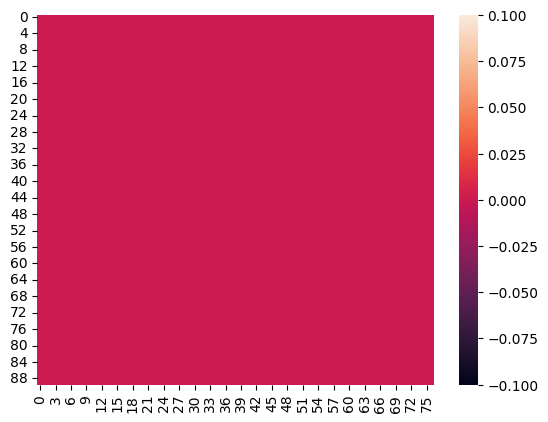

In [12]:
# matrix of t-scores for each point in the comodulogram across conditions (early/late); every point in the comodulogram (i.e. a freq. pair) has 4 exemplars (1 from each rat) per condition
t_scores_matrix = np.zeros(shape = (np.shape(example_dict['dep_freqs'])[0] - 1,np.shape(example_dict['ind_freqs'])[0]))
sns.heatmap(t_scores_matrix)

In [13]:
def t_scores_from_conditions_matrix(early_late_matrix):
  conditions,dep_freqs,ind_freqs,animals = np.shape(early_late_matrix)

  t_matrix = np.zeros(shape = [dep_freqs,ind_freqs])

  #for each point in the comodulogram surface compare data from condition 1 (early) to condition 2 (late)
  for i in range(dep_freqs):
    for j in range(ind_freqs):
      t_score = scipy.stats.ttest_rel(early_late_matrix[0,i,j,:],early_late_matrix[1,i,j,:])
      if np.isnan(t_score[0]):
        continue
      else:
        if t_score[1] <= 0.05: #if the t-test for that frequency pair has an uncorrected p-score less than or equal to 0.05
          t_matrix[i,j] = t_score[0] #then we'll store its value

  return t_matrix

<Axes: >

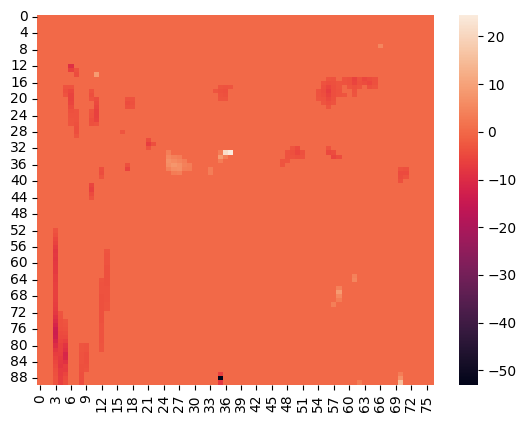

In [14]:
t_scores_matrix = t_scores_from_conditions_matrix(observed_early_late)
sns.heatmap(t_scores_matrix)

In [16]:
def binarize_t_scores_matrix(tscores_matrix):
  # initialize all values to 1; if the absolute value of an element is close to zero (remember the t-scores matrix was initialized with np.zeros()) then assign 0 to it
  binarized_matrix = np.ones_like(tscores_matrix)
  for (coords,value) in np.ndenumerate(tscores_matrix):
    if np.isclose(abs(value),0):
      binarized_matrix[coords] = 0
  return binarized_matrix

<Axes: >

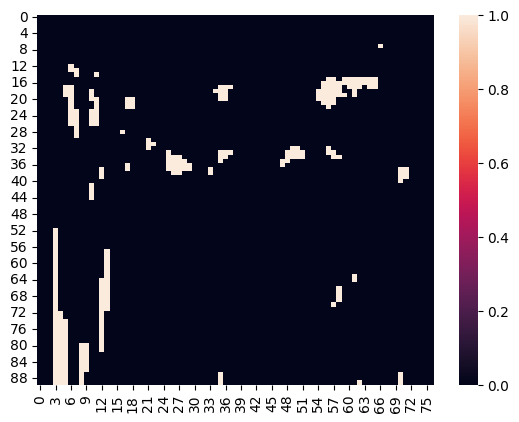

In [17]:
testando_binary = binarize_t_scores_matrix(t_scores_matrix)
sns.heatmap(testando_binary)

In [18]:
def clusters_coordinates(binarized_matrix):
  #identify clusters in a binarized matrix and return a dictionary containing the following key-value pairs:
   #{cluster:[coordinates of all its constituent elements in the matrix]}

  from skimage import measure

  # identify clusters
  labeled_clusters = measure.label(binarized_matrix)
  # estimate cluster properties
  cluster_properties = measure.regionprops(labeled_clusters)

  # out of these properties, build a dictionary featuring the coordinates of points in each cluster, hashed by an integer id
  cluster_coordinates_dict = {cluster_id:cluster.coords for cluster_id,cluster in enumerate(cluster_properties)}

  return cluster_coordinates_dict

In [19]:
clusters_test = clusters_coordinates(testando_binary)

In [20]:
def mass_value_in_cluster(tscores_matrix,cluster_coordinates):
  # sum the t-scores from all points within a cluster
  mass_value = 0

  for (i,j) in cluster_coordinates:
    mass_value += tscores_matrix[i,j] # sum the t-value in each point in the cluster
  return mass_value

# uncomment for a demonstration
mass_value_in_cluster(t_scores_matrix,clusters_test[25])

25.920665998154142

In [21]:
def set_cluster_points_to_value(tscores_matrix,cluster_coordinates,value):
  altered_matrix = tscores_matrix.copy()
  # set all points in a cluster to the same value (e.g. the mass value in the cluster, the corrected p-value, etc.)
  for (i,j) in cluster_coordinates:
    altered_matrix[i,j] = value

  return altered_matrix

In [22]:
def cluster_tscore_distribution(tscores_matrix):
  # distribution of mass values over identified clusters in the binarized (pointwise compared) t-scores matrix
  return [mass_value_in_cluster(tscores_matrix,coords) for coords in clusters_coordinates(binarize_t_scores_matrix(tscores_matrix)).values()]

In [23]:
permutated_extrema_distribution = []

for realized_permutation in possible_permutations:
  # build a possible permutation from the observed comodulograms early/late in session (see build_early_late_matrices() above)
  permutated_matrix = build_early_late_matrices(rats_list = rats,early_late_permutation_statements = realized_permutation)

  # pointwise t-score this permutated matrix
  permutated_t_scores = t_scores_from_conditions_matrix(permutated_matrix)

  #find the distribution of mass over clusters in this pointwise t-scored matrix
  current_permutation_extreme_cluster_mass = max(cluster_tscore_distribution(permutated_t_scores))

  #save it
  permutated_extrema_distribution.append(current_permutation_extreme_cluster_mass)

permutated_extrema_distribution

[486.1127921486575,
 255.33681489672276,
 260.12760071753274,
 38.534439472325644,
 97.01603849602067,
 67.77433559735286,
 144.40586144237946,
 120.50766694944767,
 531.5374265567876,
 63.08766788805185,
 130.1933674235367,
 279.96516814820495,
 83.45618243191318,
 203.28758399319324,
 159.86019610955515,
 95.3966803899711]

In [24]:
# initialize a matrix with the same dimensions as the comodulograms but filled with ones; corrected p-values for identified clusters will substitute ones in each cluster's coordinates
corrected_tscores_matrix = np.ones_like(t_scores_matrix)

for cluster_id,coordinates in clusters_test.items():
  cluster_mass = abs(mass_value_in_cluster(t_scores_matrix,coordinates))
  #print(cluster_mass)
  '''
  A cluster's p-value is the proportion of permutations whose maximum t-score is larger than the t-scored observed in this cluster (from the original data)
  See: doi:10.1016/j.jneumeth.2007.03.024 (section 2.3, step 5)
  '''
  cluster_p_value = len(np.argwhere(permutated_extrema_distribution > cluster_mass))/len(permutated_extrema_distribution)
  print(cluster_p_value)
  corrected_tscores_matrix = set_cluster_points_to_value(corrected_tscores_matrix,coordinates,cluster_p_value) # set all points in this cluster to its corrected p-value

1.0
1.0
1.0
0.375
0.8125
1.0
0.9375
1.0
1.0
1.0
0.9375
1.0
0.6875
0.875
1.0
1.0
1.0
1.0
1.0
0.0625
0.625
1.0
1.0
0.875
0.875
1.0
1.0


<Axes: >

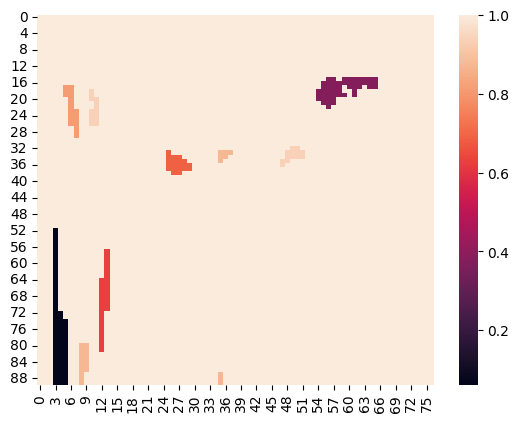

In [26]:
sns.heatmap(corrected_tscores_matrix)

In [ ]:
'''
PASSOS PRA AMANHÃ:
1. identificar clusters a partir dessa t_scores_matrix (FEITO)
2. descobrir se consigo pegar quais pontos de uma matriz pertencem a cada cluster (ideal)  (FEITO)
3. somar os valores dentro de cada cluster pra obter um _valor de massa do cluster_ (FEITO)
4. descobrir se consigo atribuir o _valor de massa_ a todos seus valores num cluster rotulado (FEITO)
4. implementar as permutações (DONE)
5. pegar o valor máximo entre as somas de todos clusters rotulados em uma comparação de comodulogramas
6. fazer 123091283 permutações (ver se eu não consigo fazer o número máximo? acho que consigo sim!) e salvar o valor mais alto de cada uma numa lista (distribuição de t-scores extremos)
7. p-value de cada cluster = ranking do valor de massa dele (percentil ocupado?) na distribuição de t-scores extremos
8. todos elementos do cluster são tingidos com o mesmo p-value; demais pontos no gráfico têm p-value = 1
'''